In [2]:
import numpy as np
import scipy as spy
import scipy.integrate as integrate
import scipy.special as special
from sympy import *
import matplotlib.pyplot as plt
from py_functions import getalpha0

In [3]:
res = 1000
kmax = 1000000
step = kmax/res
K = np.arange(1,kmax,step)


In [4]:

## Model Constants
Lp = 0.02 # [m] Initial Pouch Length - From original kellaris paper (2018)
perm0 = 8.85418782e-12#[m-3kg-1s4A2]
permr = 8e3 # for BOPP
Eb = 700e6 #[V/m] the breakdown strength of BOPP
w = 0.12 #[m] from original kellaris paper
t = 15e-6 #[m] Bopp thickness used in initial designs
#k = 10000 #[Nm-1] Achilles tendon average sourced from Litchwark 2005
rho_f = 903 #[kgm-3] Bopp Density TEKRA (2020)
rho_o = 920 #[kgm-3] FR3 Dielectric oil Density Cargill (2018)
alpf = np.pi/2 #[rad] Assume circular cross section on stroke completion
Eper = 0.5 # Percentage of electrode coverage
Va = 100 # Actuation voltage

## Swept constants
#Va = np.linspace(0,10000,1000) # 0 -> 10kV res: 10V
E = Va/(2*t)
#Eper = np.linspace(0,1,0.01)

#Lambda for force
lamb = E**2*perm0*permr*w*t

# Electrode length
Le = Lp*Eper

#optimal fill eqn based on electrode coverage ratio
# !!! MIGHT NOT WORK WITH ARRAY !!!
alpeqn = ((1-Eper)**2)*(2/np.pi) # Easy to calc constant
y = 0.01 # intial guess of angle
it = 0.0001 # iteration
scale = 1.6/it # how many possible
end = int(scale) # int for loop
for i in range(0,end): # over scale
    
    func = (y-sin(y)*cos(y))/(y**2) - alpeqn # Find value of remaining equation with embedded alpha0
    
    if func >= 0: # root is transition from negative to positive in this case
        alp0 = y - it # previous value before sign flip returned       
        break #root found, stop
    else:
        y += it #move to next guess
        continue


#Height
h = Lp*(sin(alp0)/alp0) # Height [m]

#Area w/ restraints 
# !!! MIGHT NOT WORK WITH ARRAY !!!
A = (Lp - Le)**2 /np.pi # Area [m2]

#Blocking force
Fb = (lamb)*(cos(alp0)/(1-cos(alp0)))

Lpf = Lp - Le # Fully Deformed pouch length 

xmax = h - (Lpf*(sin(alpf)/alpf)) - Le # max displacement

alp = np.linspace(alp0,alpf,res) #sweep alpha and SET RESOLUTION

# Blocks of lp(alp) eqn sweep
lpnum = 2*A*np.square(alp)
lpdom = (alp - np.sin(alp)*np.cos(alp))
lp2 = lpnum/lpdom
lp = lp2**0.5
lp[0] = Lp # Removes unphysical discretisation error

# electrode length sweep
le = Lp - lp 

# displacement sweep
lpmp = np.sin(alp)/alp # lp multiplier in x
lplpmp = lp*lpmp
X = h - lplpmp - le





In [5]:
Usee = np.zeros(res)
Uact = np.zeros(res)
eff = np.zeros(res)
for it in range(0,res):
  
    # Load of spring
    P = K[it]*X

    # Force output of actuator
    F = 5*lamb*(np.cos(alp)/(1-np.cos(alp)))

    ## Bending
    # Define new constants
    # https://www.m-petfilm.de/en/service/comparative-data-for-plastic-films/ for youngs mods

    Ymt = 4.5e9 # youngs modulus in machined direction N/m
    Ymm = 2.5e9 # yong mod in trans direction N/m 
    nu = 0.33 # Poissons ratio

    D = ((t**3)*w*Ymm)/(12*(1-nu)**2) # Bending stiffness
    k = (2*alp)/lp # Curvature of membrane

    Ub = D*k**2*lp # Bending Energy

    # Force w/ Bending
    Fwb = lamb*(np.cos(alp)/(1-np.cos(alp))) + 2*D*(alp-np.sin(alp)*np.cos(alp)/A) * (np.cos(alp)/(1-np.cos(alp))) * (1+(2*alp*np.tan(alp)**2)/(alp-np.tan(alp)))
    # Loop deletes anyhting after spring outforces actuator
    for i in range(len(X)):
        if F[i] <= P[i]:
            cut = i
            for j in range(i+1,len(X)):
                F[j] = float("NaN")
                P[j] = float("NaN")
        else:
            continue
    
    x = X[0:cut] # Physically relevant values for integration 

    p = P[0:cut]

    f = F[0:cut]

    Uact[it] = spy.integrate.trapezoid(f,x)
    Usee[it] = spy.integrate.trapezoid(p,x)
    eff[it] = Usee[it]/Uact[it]*100
    best = np.argmax(Usee)
    



In [6]:
print(eff[best])
print(Usee[best])
print(K[best])

23.4168138420549
0.009887210661462765
119001.0


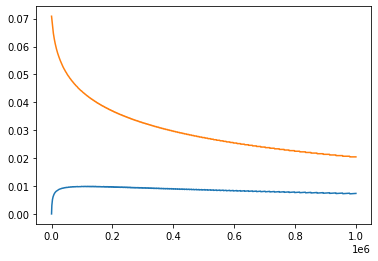

In [7]:
fig, ax = plt.subplots()
ax.plot(K,Usee)
ax.plot(K,Uact)

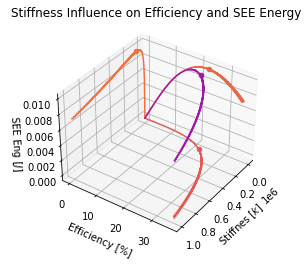

In [8]:
fig= plt.figure()
x= K
y= eff
z= Usee
ax= fig.add_subplot(111, projection= '3d')
ax.plot(x, z, '#f56e3d', zdir='y')
ax.plot(y, z, '#eb6549', zdir='x')
ax.plot(x, y, '#e25b55'  ,zdir='z')
ax.scatter(x[best], z[best], color='#f56e3d', zdir='y')
ax.scatter(y[best], z[best],color= '#eb6549', zdir='x')
ax.scatter(x[best], y[best], color='#e25b55'  ,zdir='z')
ax.plot(x,y,z,color = '#9f19a8')
ax.scatter(x[best],y[best],z[best],color='#9f19a8')
ax.set_xlabel("Stiffnes "r"[$k$]")
ax.set_ylabel("Efficiency "r"[%]")
ax.set_zlabel("SEE Eng " r"[$J$]")
plt.title("Stiffness Influence on Efficiency and SEE Energy")


ax.view_init(35, 35)


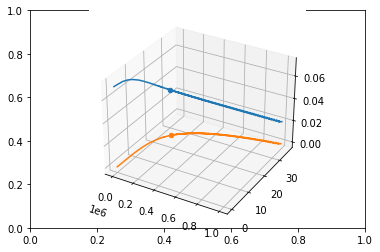

In [9]:
fig, ax = plt.subplots()
ax = plt.axes(projection='3d')
ax.plot3D(K,eff,Uact)
ax.scatter(K[best],eff[best],Uact[best])
ax.plot(K,eff, zdir='Uact')

ax.scatter(K[best],eff[best],zdir='Uact')



In [10]:
k = K[best]
P = k*X 
# Force output of actuator
F = lamb*(np.cos(alp)/(1-np.cos(alp)))

## Bending
# Define new constants
# https://www.m-petfilm.de/en/service/comparative-data-for-plastic-films/ for youngs mods

Ymt = 4.5e9 # youngs modulus in machined direction N/m
Ymm = 2.5e9 # yong mod in trans direction N/m 
nu = 0.33 # Poissons ratio

D = ((t**3)*w*Ymm)/(12*(1-nu)**2) # Bending stiffness
k = (2*alp)/lp # Curvature of membrane

Ub = D*k**2*lp # Bending Energy

# Force w/ Bending
Fwb = lamb*(np.cos(alp)/(1-np.cos(alp))) + 2*D*(alp-np.sin(alp)*np.cos(alp)/A) * (np.cos(alp)/(1-np.cos(alp))) * (1+(2*alp*np.tan(alp)**2)/(alp-np.tan(alp)))
# Loop deletes anyhting after spring outforces actuator
for i in range(len(X)):
    if F[i] <= P[i]:
        cut = i
        for j in range(i+1,len(X)):
            F[j] = float("NaN")
            P[j] = float("NaN")
    else:
        continue

x = X[0:cut] # Physically relevant values for integration 

p = P[0:cut]

f = F[0:cut]

Uact = spy.integrate.trapezoid(f,x)
Usee = spy.integrate.trapezoid(p,x)
eff = Usee/Uact*100
print(eff) 

32.8208064761963


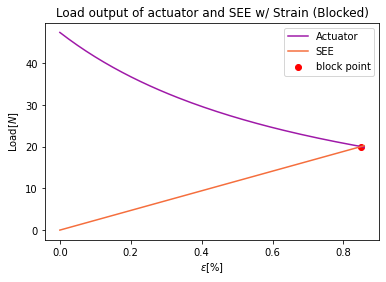

In [11]:
strain = X/h*100
fig, ax = plt.subplots()
ax.scatter(strain[cut-1],p[cut-1],color='red',label='block point') 
ax.plot(strain,F, color='#9F19A8', label='Actuator')
ax.plot(strain,P,color='#F56E3D', label='SEE')
# plt.annotate("Block Point", (strain[cut],P[cut]), (strain[cut]-0.3,P[cut]+2))
plt.xlabel(r"$\epsilon [\%]$")
plt.ylabel(r"Load"r"$[N]$")
plt.title(r"Load output of actuator and SEE w/ Strain (Blocked)")
leg = plt.legend(loc = 'upper right')

In [12]:

mass = (Lp*t*w*2*rho_f + A*w*rho_o) # film + oil mass

uact = Uact/mass
usee = Usee/mass
print(usee)
print(uact)


0.469659451559562
1.43098083802477
